In [1]:
import warnings
warnings.simplefilter(action='ignore',)

import multiprocessing
import multiprocessing as mp
from time import time
from multiprocessing import Queue
print("Number of cpu : ", multiprocessing.cpu_count())

from qiskit import Aer, QuantumCircuit
from qiskit.utils import QuantumInstance
from qiskit.circuit import ParameterVector
from qiskit_machine_learning.kernels import QuantumKernel
quantum_instance = QuantumInstance(Aer.get_backend('qasm_simulator'), shots=128)

import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.colors
CMAP = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#EE9A4D","#FFFFFF","#4863A0"])

import sys 
sys.path.append('..')
from time import time
from circuit_generate import generate_circuit_paper, generate_circuit_2local, generate_circuit_2local_swap

import seaborn as sns
from sklearn import datasets
from sklearn.svm import SVC
sns.set_style("whitegrid")

Number of cpu :  12


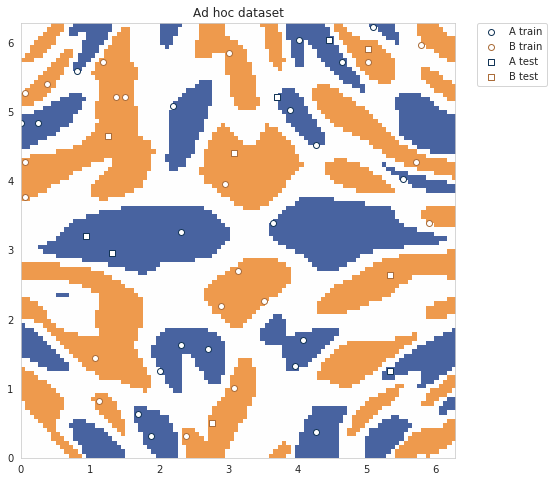

In [2]:
from qiskit_machine_learning.datasets import ad_hoc_data
train_x, train_y, test_x, test_y, total = (ad_hoc_data(training_size=20, test_size=5, n=2, gap=0.3, include_sample_total=True, one_hot=False))

plt.figure(figsize=(8,8))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
plt.imshow(
    np.asmatrix(total).T,
    interpolation="nearest",
    origin="lower",
    cmap=CMAP,
    extent=[0, 2 * np.pi, 0, 2 * np.pi])

plt.scatter(
    train_x[np.where(train_y[:] == 0), 0], train_x[np.where(train_y[:] == 0), 1],
    marker="o", facecolors="w", edgecolors="#123456", label="A train")

plt.scatter(
    train_x[np.where(train_y[:] == 1), 0], train_x[np.where(train_y[:] == 1), 1],
    marker="o", facecolors="w", edgecolors="#AA6C39", label="B train")

plt.scatter(
    test_x[np.where(test_y[:] == 0), 0], test_x[np.where(test_y[:] == 0), 1],
    marker="s", facecolors="w", edgecolors="#123456", label="A test")

plt.scatter(
    test_x[np.where(test_y[:] == 1), 0], test_x[np.where(test_y[:] == 1), 1],
    marker="s", facecolors="w", edgecolors="#AA6C39", label="B test")

plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset")
plt.grid(False)
plt.show()

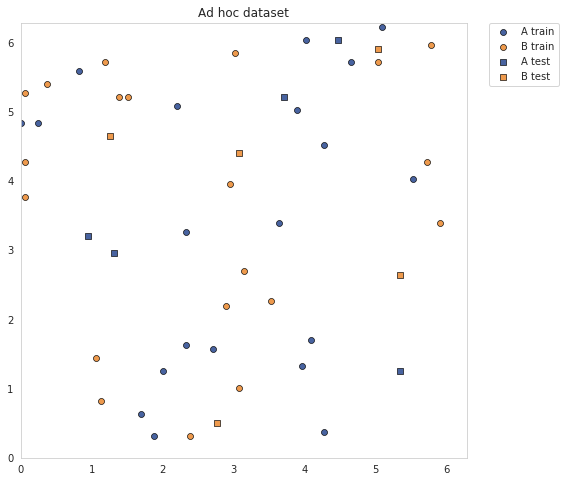

In [3]:
plt.figure(figsize=(8,8))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)

plt.scatter(
    train_x[np.where(train_y[:] == 0), 0], train_x[np.where(train_y[:] == 0), 1],
    marker="o", color="#4863A0", edgecolors="k", linewidths=0.64, label="A train")

plt.scatter(
    train_x[np.where(train_y[:] == 1), 0], train_x[np.where(train_y[:] == 1), 1],
    marker="o", color="#EE9A4D", edgecolors="k", linewidths=0.64, label="B train")

plt.scatter(
    test_x[np.where(test_y[:] == 0), 0], test_x[np.where(test_y[:] == 0), 1],
    marker="s", color="#4863A0", edgecolors="k", linewidths=0.64, label="A test")

plt.scatter(
    test_x[np.where(test_y[:] == 1), 0], test_x[np.where(test_y[:] == 1), 1],
    marker="s", color="#EE9A4D", edgecolors="k", linewidths=0.64, label="B test")

plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc dataset")
plt.grid(False)
plt.show()

##### Parameter

In [4]:
MODE = "2local" # paper、2local、2local_swap

QUBIT = 2
FEATURE = 2
BIT = 5 if MODE == "paper" else 6

GENE = 20
POPULATION = multiprocessing.cpu_count() # 12

POOLSIZE = 4
OFFSPRINGSIZE = POPULATION - POOLSIZE

PROB = 12
MUTATION_PROB = PROB/GENE

GENERATION = 200
EARLYSTOP = 20

##### Multi-task QSVM

In [5]:
def task(i, pop, q, mode):
    if mode == "paper": qc_i, r_i, h_i, cnot_i = generate_circuit_paper(pop[i], QUBIT, FEATURE)
    elif mode == "2local": qc_i, r_i, h_i, cnot_i = generate_circuit_2local(pop[i], QUBIT, FEATURE)
    elif mode == "2local_swap": qc_i, r_i, h_i, cnot_i, swap_i = generate_circuit_2local_swap(pop[i], QUBIT, FEATURE)
    kernel = QuantumKernel(feature_map=qc_i, quantum_instance=quantum_instance,)
    model = SVC(kernel=kernel.evaluate)
    model.fit(train_x, train_y)
    score = model.score(test_x, test_y)
#     print("Score : {:3f}, r_i : {:3d}, h_i : {:3d}, cnot_i : {:3d}".format(score, r_i, h_i, cnot_i))
    if mode == "paper": q.put([score, r_i, h_i, cnot_i])
    elif mode == "2local": q.put([score, r_i, h_i, cnot_i])
    elif mode == "2local_swap": q.put([score, r_i, h_i, cnot_i, swap_i])

##### Pareto front

In [6]:
def pareto_front(t_list):
    pareto_index = []
    tt_list = t_list.copy()
    
    for j in range(POPULATION):     
        min_pareto, min_index = [tt_list[0][0], tt_list[0][1]], 0
  
        for i in range(POPULATION-j):
            if tt_list[i][0] >= min_pareto[0] and tt_list[i][1] <= min_pareto[1]:
                min_pareto, min_index = [tt_list[i][0], tt_list[i][1]], i

        copy_index = [i for i,val in enumerate(t_list) if val==min_pareto]
        for r in copy_index: pareto_index.append(r)
        
        del tt_list[min_index]
  
    return pareto_index

def cost_gate(r,h,cnot,swap=0): return r+2*h+5*cnot+11*swap

##### Iterate


Generation: 1 , Time: 23.96 s
Accuracy: [0.5, 0.7, 0.7, 0.1, 0.8, 0.4, 0.6, 0.6, 0.5, 0.3, 0.6, 0.6]
Gate cost: [30, 32, 21, 24, 30, 35, 29, 21, 40, 41, 22, 24]

Generation: 2 , Time: 48.58 s
Accuracy: [0.7, 0.7, 0.5, 0.7, 0.6, 0.6, 0.1, 0.4, 0.6, 0.7, 0.5, 0.7]
Gate cost: [21, 30, 21, 22, 19, 22, 21, 25, 31, 35, 28, 23]

Generation: 3 , Time: 72.65 s
Accuracy: [0.6, 0.6, 0.6, 0.6, 0.5, 0.7, 0.7, 0.6, 0.6, 0.6, 0.5, 0.5]
Gate cost: [21, 22, 23, 30, 31, 25, 31, 37, 28, 16, 31, 19]

Generation: 4 , Time: 96.82 s
Accuracy: [0.5, 0.8, 0.7, 0.7, 0.5, 0.6, 0.6, 0.7, 0.5, 0.6, 0.8, 0.7]
Gate cost: [16, 21, 22, 23, 18, 36, 17, 19, 27, 12, 29, 16]

Generation: 5 , Time: 121.46 s
Accuracy: [0.5, 0.8, 0.6, 0.7, 0.5, 0.6, 0.6, 0.8, 0.8, 0.7, 0.4, 0.6]
Gate cost: [12, 16, 16, 21, 18, 20, 16, 21, 27, 11, 16, 25]

Generation: 6 , Time: 145.18 s
Accuracy: [0.8, 0.4, 0.7, 0.6, 0.4, 0.7, 1.0, 0.5, 0.4, 0.5, 0.6, 0.6]
Gate cost: [11, 12, 16, 16, 22, 16, 20, 21, 18, 13, 11, 20]

Generation: 7 , Time: 168

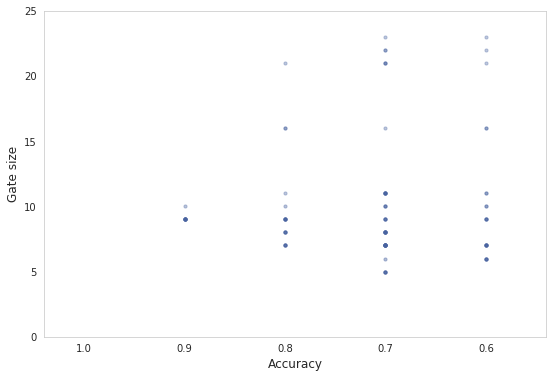

In [7]:
pop, obj_GATE, obj_ACC= [], [], []
early_stop, threshold= 0, [0.1,100]

sns.set_style("whitegrid")
plt.figure(figsize=(9,6))
plt.xlim(1.04,0.54)
plt.ylim(0,25)
plt.xlabel("Accuracy", fontsize=12)
plt.ylabel("Gate size", fontsize=12)
plt.grid(False)

for i in range(POPULATION):
    genes = np.random.randint(2, size=(GENE,BIT))
    pop.append(genes)
    
start_time = time()
for g in range(GENERATION):

    inputs = range(POPULATION)
    process_list= []

    q_list = [Queue() for i in range(len(inputs))]
    RESULt = []

    for i in inputs:
        process_list.append(mp.Process(target = task, args = (i, pop,  q_list[i], MODE)))
        process_list[-1].start()

    for i in inputs:
        process_list[i].join()

    for q in q_list:
        RESULt.append(q.get())
    
    end_time = time()

    FITNESS, SCORE, GATECOST, QC_R, QC_H, QC_CNOT, QC_SWAP, plt_acc, plt_gate = [], [], [], [], [], [], [], [], []
    cost_pool ,obj_gate, obj_acc = 0, 0, 0

    for i in range(POPULATION):
        SCORE.append(round(RESULt[i][0],2))
        QC_R.append(RESULt[i][1])
        QC_H.append(RESULt[i][2])
        QC_CNOT.append(RESULt[i][3])
        if MODE == "2local_swap": QC_SWAP.append(RESULt[i][4])
        
    for i in range(POPULATION):
        if MODE == "2local_swap": gcost = cost_gate(QC_R[i], QC_H[i], QC_CNOT[i], QC_SWAP[i])
        else: gcost = cost_gate(QC_R[i], QC_H[i], QC_CNOT[i])
        GATECOST.append(gcost)
    
    for i in range(POOLSIZE):
        if MODE == "2local_swap": obj_g = cost_gate(QC_R[i], QC_H[i], QC_CNOT[i], QC_SWAP[i])
        else: obj_g = cost_gate(QC_R[i], QC_H[i], QC_CNOT[i])
        obj_a = SCORE[i]
        
        plt_gate.append(obj_g)
        plt_acc.append(obj_a)
        obj_gate += obj_g
        obj_acc += obj_a
        
    if SCORE[0] > threshold[0] and GATECOST[0] < threshold[1]: 
        threshold = [SCORE[0],GATECOST[0]]
        early_stop = 0 
    early_stop += 1
    
    obj_GATE.append(obj_gate/POOLSIZE)
    obj_ACC.append(obj_acc/POOLSIZE)
    plt.scatter(plt_acc, plt_gate, s=10, c="#4863A0", alpha=(g+GENERATION/2)/(1.5*GENERATION))
    
    print("\nGeneration:", g+1,", Time:", round(end_time-start_time,2),"s")
    print("Accuracy:", SCORE)
    print("Gate cost:", GATECOST)

    if g == GENERATION: break
    if early_stop == EARLYSTOP: break

    parents, t_PARETO = [], []
    for i in range(POPULATION):
        tt = [SCORE[i], GATECOST[i]]
        t_PARETO.append(tt)

    pareto_list = pareto_front(t_PARETO)
    for i in pareto_list:  
        if i not in FITNESS: FITNESS.append(i)
#     print("Index:",FITNESS)
    
    for i in range(POOLSIZE):
        FitnessIndex = FITNESS[i]
        parents.append(pop[FitnessIndex])

    for i in range(OFFSPRINGSIZE):
        ll,rr = np.random.randint(POOLSIZE), np.random.randint(POOLSIZE) 
        parent_left, parent_right = parents[ll], parents[rr]
        cross_point = np.random.randint(GENE-1) 
        offspring = np.concatenate((parent_left[:cross_point],parent_right[cross_point:]), axis=0)

        for ii in range(PROB):
            mutation_index = np.random.randint(GENE) 
            mutation_bit = np.random.randint(BIT) 
            offspring[mutation_index][mutation_bit] = (offspring[mutation_index][mutation_bit]+1)%2

        parents.append(offspring)       
    pop = parents    
plt.show()

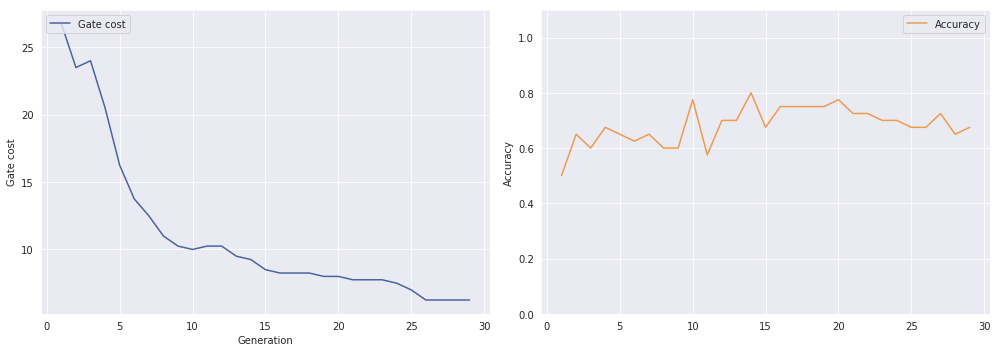

In [8]:
sns.set_style("darkgrid")
obj_x, obj_y1, obj_y2 = np.arange(len(obj_ACC)), np.array(obj_GATE), np.array(obj_ACC)
# cost_x, cost_y = np.arange(GENERATION), np.array(COST)

fig, axes = plt.subplots(1,2, figsize=(14,5))

ax1=axes[0]
ax1.set_xlabel('Generation')
ax1.set_ylabel('Gate cost')
ax1.plot(obj_x+1, obj_y1, label="Gate cost", color="#4863A0")
ax1.tick_params(axis='y')

ax2 = axes[1]
ax1.set_xlabel('Generation')
ax2.set_ylabel('Accuracy')
ax2.plot(obj_x+1, obj_y2, label="Accuracy", color="#EE9A4D")
ax2.tick_params(axis='y')
ax2.set_ylim(0, 1.1)

ax1.legend(loc="upper left")
ax2.legend(loc="upper right")


fig.tight_layout() 
plt.show()

R gate: 5 
H gate: 0 
CNOT gate: 0


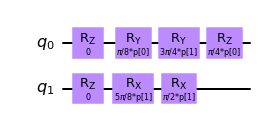

In [9]:
DISPLAY = 1
if MODE == "paper":
    qc_display, r_display, h_display, cnot_display = generate_circuit_paper(pop[DISPLAY-1], QUBIT, FEATURE)
    print("R gate:",r_display,"\nH gate:",h_display,"\nCNOT gate:",cnot_display)
if MODE == "2local":
    qc_display, r_display, h_display, cnot_display = generate_circuit_2local(pop[DISPLAY-1], QUBIT, FEATURE)
    print("R gate:",r_display,"\nH gate:",h_display,"\nCNOT gate:",cnot_display)
if MODE == "2local_swap":
    qc_display, r_display, h_display, cnot_display, swap_display = generate_circuit_2local_swap(pop[DISPLAY-1], QUBIT, FEATURE)
    print("R gate:",r_display,"\nH gate:",h_display,"\nCNOT gate:",cnot_display,"\nSWAP gate:",swap_display)    
qc_display.draw(output="mpl")

In [10]:
ga_kernel = QuantumKernel(feature_map=qc_display, quantum_instance=quantum_instance,)
model_ga = SVC(kernel=ga_kernel.evaluate)
qsvm = model_ga.fit(train_x, train_y)
q_score = model_ga.score(test_x, test_y)

print(f'Test kernel acc: {q_score}')

Test kernel acc: 0.7


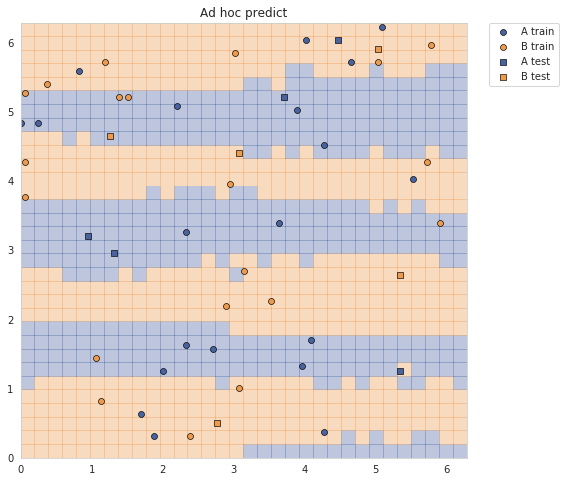

QSVM test score: 0.7
Cost time: 293.067672 s


In [11]:
GRID = np.pi/16 # pi/32:1600s

sns.set_style("whitegrid")
def make_big_meshgrid(x, y, h=GRID): 
    xx, yy = np.meshgrid(np.arange(0, 2*np.pi+GRID, h), np.arange(0, 2*np.pi+GRID, h))
    return xx, yy

def plot_contours(ax, clf, xx, yy, **params):
    Z = clf.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    out = ax.contourf(xx, yy, Z, **params)
    return out

X0, X1 = train_x[:, 0], train_x[:, 1]
bbxx, bbyy = make_big_meshgrid(X0, X1)
bbmeshgrid_features = np.column_stack((bbxx.ravel(), bbyy.ravel()))

meshgrid_time1 = time()

cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["#4863A0","#EE9A4D"])
meshgrid_colors = qsvm.predict(bbmeshgrid_features)

plt.figure(figsize=(8,8))
plt.ylim(0, 2 * np.pi)
plt.xlim(0, 2 * np.pi)
meshgrid_colors = meshgrid_colors.reshape(bbxx.shape)
plt.pcolormesh(bbxx, bbyy, meshgrid_colors, cmap=cmap, alpha=0.36)

plt.scatter(
    train_x[np.where(train_y[:] == 0), 0], train_x[np.where(train_y[:] == 0), 1],
    marker="o", color="#4863A0", edgecolors="k", linewidths=0.64, label="A train")

plt.scatter(
    train_x[np.where(train_y[:] == 1), 0], train_x[np.where(train_y[:] == 1), 1],
    marker="o", color="#EE9A4D", edgecolors="k", linewidths=0.64, label="B train")

plt.scatter(
    test_x[np.where(test_y[:] == 0), 0], test_x[np.where(test_y[:] == 0), 1],
    marker="s", color="#4863A0", edgecolors="k", linewidths=0.64, label="A test")

plt.scatter(
    test_x[np.where(test_y[:] == 1), 0], test_x[np.where(test_y[:] == 1), 1],
    marker="s", color="#EE9A4D", edgecolors="k", linewidths=0.64, label="B test")

plt.legend(bbox_to_anchor=(1.05,1), loc="upper left", borderaxespad=0.0)
plt.title("Ad hoc predict")
plt.grid(False)
plt.show()

print(f'QSVM test score: {q_score}')

meshgrid_time2 = time()
print("Cost time: {:3f} s".format(meshgrid_time2-meshgrid_time1))